In [ ]:
import urllib.request, os
filedir = os.path.dirname(os.path.abspath("./mnist"))
filepath = os.path.join(filedir, "mnist.pkl.gz")
if not os.path.exists(filepath):
    urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz",
                               filepath)
    print("mnist data downloaded.")
else:
    print("mnist data already downloaded.")

In [ ]:
import sys
sys.path.append('..')

from __future__ import absolute_import

from importlib import reload
from paysage import batch
from paysage import layers
from paysage.models import model
from paysage import fit
from paysage import optimizers
from paysage import backends as be
from paysage import schedules

be.set_seed(137) # for determinism

import example_util as util

paysage_path=None
num_epochs=10
show_plot=False

num_hidden_units = 500
batch_size = 100
learning_rate = schedules.power_law_decay(initial=1e-2, coefficient=0.1)
mc_steps = 1

(_, _, shuffled_filepath) = \
        util.default_paths(paysage_path)

# set up the reader to get minibatches
data = batch.NumpyBatch('../mnist/mnist.pkl.gz',
                        batch_size, True, limit=1e-2,
                        # input_transform=batch.binarize_color,
                        # numpy batch inputs are already binarized
                        target_transform=lambda x: be.onehot(x, 10))

try:
    import torch
    torch.cuda.set_device(0)
except ImportError:
    print('No CUDA support.')
    
# set up the model and initialize the parameters
vis_layer = layers.BernoulliLayer(data.ncols)
hid_layer = layers.BernoulliLayer(num_hidden_units)
clf_layer = layers.ClassificationLayer(10)

rbm = model.Model([vis_layer,
                   hid_layer,
                   clf_layer])
rbm.initialize(data, 'glorot_normal')

metrics = ['ReconstructionError', 'Accuracy', 'CrossEntropy']
perf = fit.ProgressMonitor(data, metrics=metrics)

# set up the optimizer and the fit method
opt = optimizers.ADAM(stepsize=learning_rate)
sampler = fit.DrivenSequentialMC.from_batch(rbm, data)

# use a batch with targets
sgd = fit.SGD(rbm, data, opt, 400,
              method=fit.pcd,
              sampler=sampler,
              mcsteps=mc_steps,
              monitor=perf)

# fit the model
sgd.train()

### priorities:
* cd - OK, pcd - OK (both: Accuracy 0.92 at 1000 epochs), tap - needs work in layer
* sequential - OK, driven_sequential - OK
* gradient - not working, adam - OK
* gaussian inputs - OK - too slow with lr=1e-1
* numpy batch feed - DONE

### TODO:
* make DBM work
* regression - gaussian/exponential/poisson outputs 
* try to use autograd
* multimodality of inputs

In [22]:
# evaluate the model    
util.show_metrics(rbm, perf)
valid = data.get('validate')

Final performance metrics:
-ReconstructionError: 5.772199
-Accuracy: 0.910000
-CrossEntropy: 1.551151


In [23]:
%matplotlib inline


Plot a random sample of reconstructions
Class predictions: [1 8 2 0 8 9 1 3 1 3]


/opt/conda/envs/pytorch-py35/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


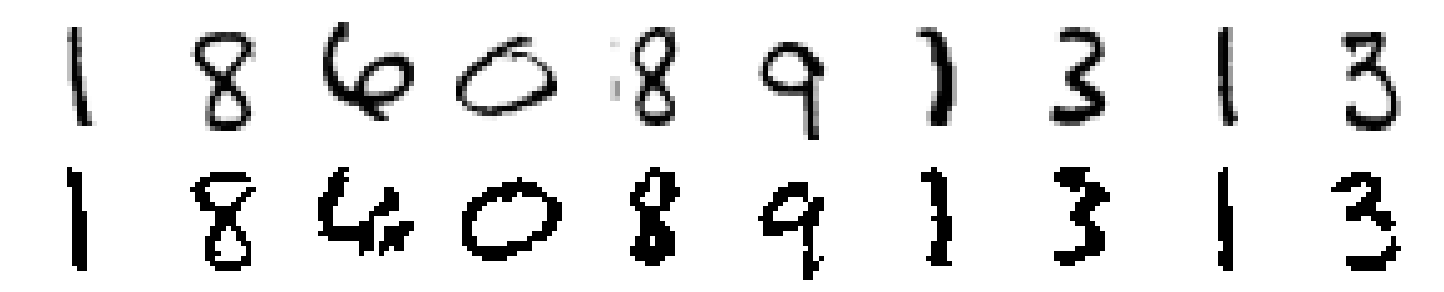

In [39]:
util.show_reconstructions(rbm, valid, fit, show_plot=True, n_recon=10, vertical=False)

In [ ]:
util.show_fantasy_particles(rbm, valid, fit, show_plot=True, n_fantasy=25)
util.show_weights(rbm, show_plot=True, n_weights=25)